<a href="https://colab.research.google.com/github/Goktuginal/goktuginal.github.io/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x


TensorFlow 1.x selected.


In [3]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

Using TensorFlow backend.


In [5]:
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [9]:
content_image=Image.open('upv.png')
content_image=content_image.resize((512,512))

In [10]:
style_image= Image.open('style.png')
style_image=style_image.resize((512,512))

In [11]:
style_image.size

(512, 512)

In [12]:
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)
#content_array=np.array(content_array).copy()

In [13]:
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
#backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))style_array=np.array(style_array).copy()
print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [14]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array=content_array[:, :, :, ::-1]

In [15]:
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array=style_array[:, :, :, ::-1]
style_array.shape

(1, 512, 512, 3)

In [16]:
height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

In [18]:
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)


58892288/58889256 [==============================] - 1s 0us/step


In [19]:
content_weight = 0.05
style_weight = 5.0
total_variation_weight = 1.0

In [20]:
layers=dict([(layer.name, layer.output) for layer in model.layers])

In [21]:
loss=backend.variable(0.)

In [22]:
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

In [24]:
layer_features=layers['block2_conv2']
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss = loss + content_weight*content_loss(content_image_features,combination_features)

In [25]:
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

In [26]:
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [27]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']


In [28]:
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl

In [29]:
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

In [30]:
grads = backend.gradients(loss, combination_image)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [31]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [32]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [33]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [34]:
evaluator=Evaluator()

In [35]:
x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 10

In [36]:
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
94255820000.0
Iteration 0 completed in 457s
Start of iteration 1
55591256000.0
Iteration 1 completed in 453s
Start of iteration 2
44393430000.0
Iteration 2 completed in 455s
Start of iteration 3
41441903000.0
Iteration 3 completed in 450s
Start of iteration 4
40333640000.0
Iteration 4 completed in 451s
Start of iteration 5
39731250000.0
Iteration 5 completed in 452s
Start of iteration 6
39329112000.0
Iteration 6 completed in 451s
Start of iteration 7
39068525000.0
Iteration 7 completed in 453s
Start of iteration 8
38898147000.0
Iteration 8 completed in 454s
Start of iteration 9
38782775000.0
Iteration 9 completed in 456s


In [37]:
print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

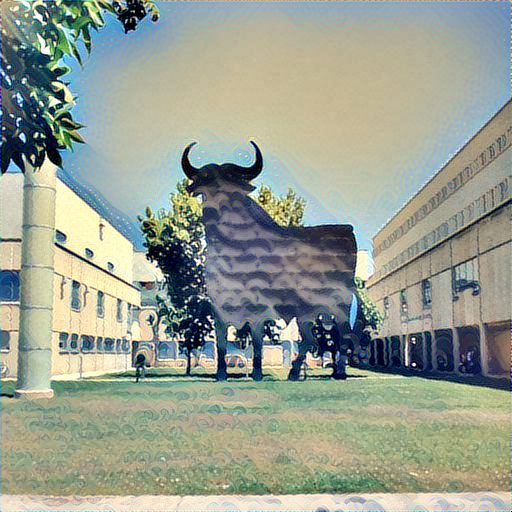

In [38]:
Image.fromarray(x)